In [77]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms


model_utils.fix_random(42)

In [2]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),            # Resize the shorter side to 128 while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is exactly 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.10), dataset=dataset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


In [4]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

In [14]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "FTRes50_newdata", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 61.9%, Avg loss: 0.680015 

new best model found
best model saved
Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 56.7%, Avg loss: 0.687354 

Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 63.9%, Avg loss: 0.584070 

new best model found
best model saved
Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 72.2%, Avg loss: 0.670145 

Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 62.9%, Avg loss: 0.576025 

new best model found
best model saved
Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 68.0%, Avg loss: 0.526899 

new best model found
best model saved
Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 70.1%, Avg loss: 0.579171 

Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 72.2%, Avg loss: 0.670575 

Epoch 9/20
-------------------------------
Validation Er

In [15]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 77.3%, Avg loss: 0.462071 



(0.4620706524167742, tensor(0.7732, device='cuda:0'))

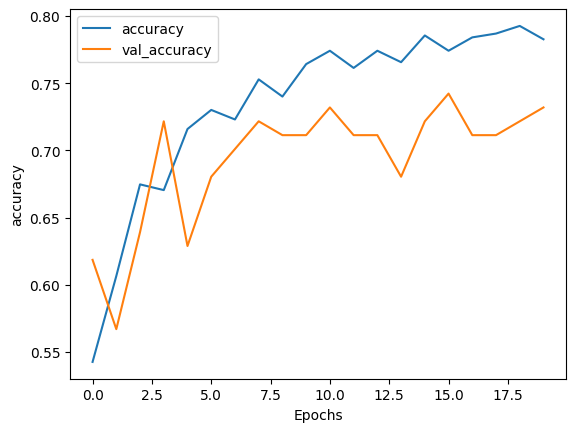

In [16]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

Step2 FT

In [8]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [8]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "FTRes50NewData_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\tekke\ethics_project2\model_utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [19]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.6%, Avg loss: 0.440720 



(0.44072031655481886, tensor(0.8557, device='cuda:0'))

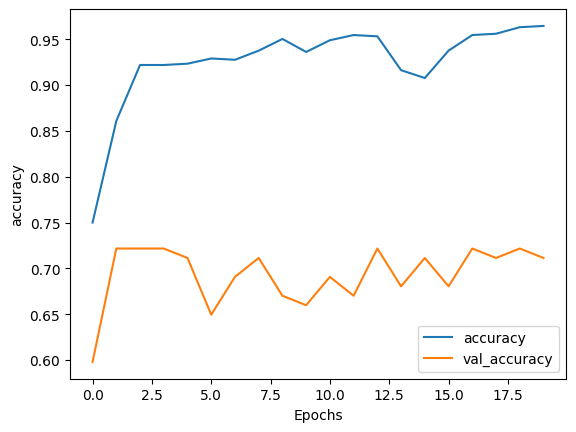

In [20]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts 
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

GradCAM Test

100%|██████████| 64/64 [00:04<00:00, 14.02it/s]


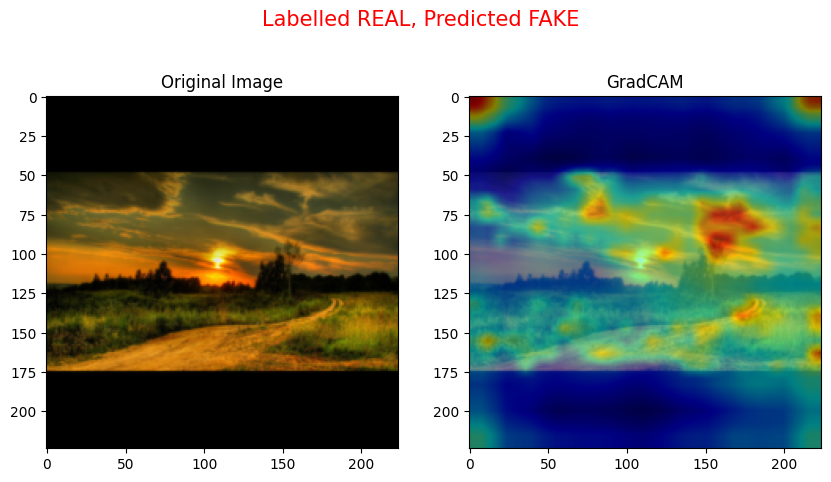

In [7]:
import xai
importlib.reload(xai)
xai.explain_gradcam_single_image(train_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                index = 3)

100%|██████████| 64/64 [00:04<00:00, 14.05it/s]


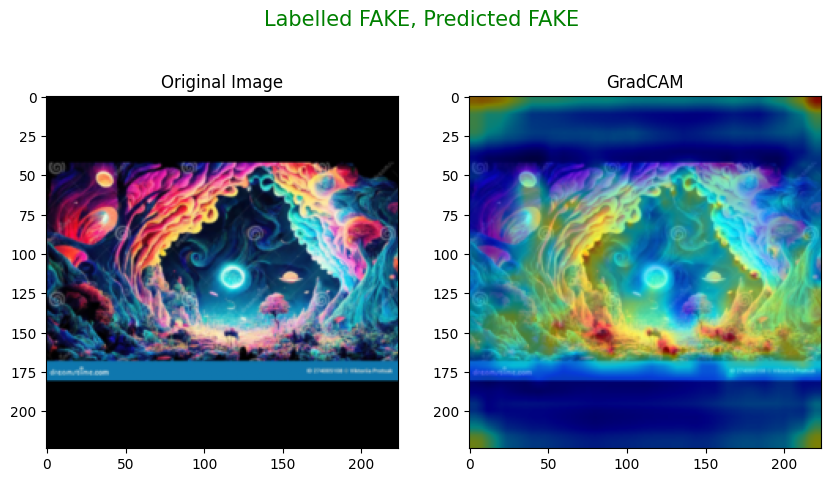

In [10]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                index = 2)

### Data Augmentation Experiment
ignore if it not worky welly.

In [79]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [89]:
original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)
augmented_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform)


augmented_size = int(0.3 * len(original_dataset))

import numpy as np

augmented_indices = np.random.choice(len(augmented_dataset), augmented_size, replace=False)
augmented_subset = Subset(augmented_dataset, augmented_indices)

# Combine the subsets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.10), dataset=combined_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = (train_dataloader, val_dataloader)

In [90]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

In [91]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "FTRes50_experiment", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training loss: 0.656924, train accuracy: 56.02%  [ 1280/ 1358]
Validation Error:
Accuracy: 55.7%, Avg loss: 0.653590 

new best model found
best model saved
Epoch 2/20
-------------------------------
training loss: 0.627739, train accuracy: 65.16%  [ 1280/ 1358]
Validation Error:
Accuracy: 68.0%, Avg loss: 0.609734 

new best model found
best model saved
Epoch 3/20
-------------------------------
training loss: 0.565737, train accuracy: 67.81%  [ 1280/ 1358]
Validation Error:
Accuracy: 72.2%, Avg loss: 0.603620 

new best model found
best model saved
Epoch 4/20
-------------------------------
training loss: 0.549854, train accuracy: 70.00%  [ 1280/ 1358]
Validation Error:
Accuracy: 59.3%, Avg loss: 0.595899 

new best model found
best model saved
Epoch 5/20
-------------------------------
training loss: 0.555162, train accuracy: 70.86%  [ 1280/ 1358]
Validation Error:
Accuracy: 69.6%, Avg loss: 0.569198 

new best model found
best model saved
Epoch 6/20
-------------------------------


c:\Users\tekke\ethics_project2\model_utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [92]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 72.7%, Avg loss: 0.550447 



(0.5504472164007334, tensor(0.7268, device='cuda:0'))

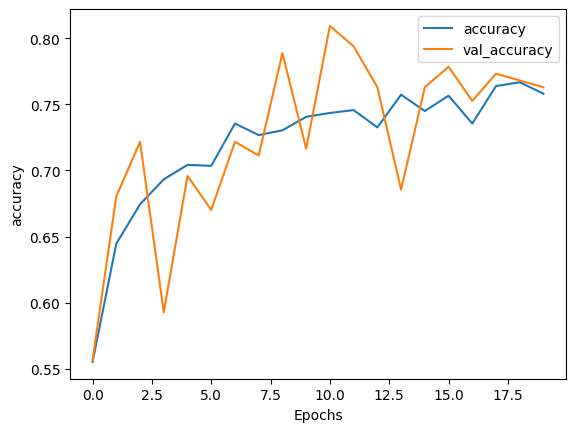

In [93]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

In [94]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [98]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "FTRes50_expriment_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training loss: 0.412510, train accuracy: 75.23%  [ 1280/ 1358]
Validation Error:
Accuracy: 79.4%, Avg loss: 0.463510 

new best model found
best model saved
Epoch 2/20
-------------------------------
training loss: 0.444755, train accuracy: 83.12%  [ 1280/ 1358]
Validation Error:
Accuracy: 77.3%, Avg loss: 0.518716 

Epoch 3/20
-------------------------------
training loss: 0.388076, train accuracy: 85.62%  [ 1280/ 1358]
Validation Error:
Accuracy: 81.4%, Avg loss: 0.324324 

new best model found
best model saved
Epoch 4/20
-------------------------------
training loss: 0.189549, train accuracy: 87.42%  [ 1280/ 1358]
Validation Error:
Accuracy: 76.3%, Avg loss: 0.655975 

Epoch 5/20
-------------------------------
training loss: 0.383974, train accuracy: 86.88%  [ 1280/ 1358]
Validation Error:
Accuracy: 81.4%, Avg loss: 0.344421 

Epoch 6/20
-------------------------------
training loss: 0.199485, train accuracy: 89.14%  [ 1280/ 1358]
Validation Error:
Accuracy: 75.3%, Avg loss: 0.6308

c:\Users\tekke\ethics_project2\model_utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [99]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 83.5%, Avg loss: 0.468671 



(0.4686706020281865, tensor(0.8351, device='cuda:0'))

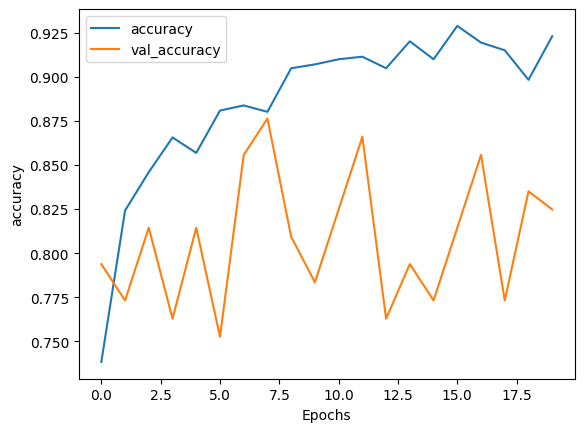

In [100]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts 
    plotter.plot_metrics((train_accs, test_accs), "accuracy")